## Kue Dataset - Model2

overfit model2


In [17]:
# conda install -c conda-forge keras

In [18]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# PATH_DATA = '../data/'
# PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_IMAGES = 'drive/MyDrive/Repository/Data/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = 'drive/MyDrive/Repository/Model/'

In [5]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_risoles',
 'kue_klepon',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_lapis',
 'kue_serabi']

## Modeling

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


In [7]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [9]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [38]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 128

In [39]:
# ?Conv2D

In [67]:
# just_cake_model = Sequential()
# just_cake_model.add(Conv2D(128, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# just_cake_model.add(Conv2D(128, (3, 3), activation ='relu',padding='same'))
# just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
# just_cake_model.add(Conv2D(256, (3, 3), activation ='relu'))
# just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
# just_cake_model.add(Conv2D(256, (3, 3), activation ='relu'))
# just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
# just_cake_model.add(Conv2D(256, (3, 3), activation ='relu'))
# just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
# just_cake_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# just_cake_model.add(Dense(64, activation ='relu'))
# just_cake_model.add(Dense(16, activation ='relu'))
# just_cake_model.add(Dense(8, activation ='relu'))
# just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

just_cake_model = load_model(PATH_MODEL +'just_cake_model-colab3.h5',compile=False)

In [68]:
just_cake_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0

In [69]:
## compile model
opt = optimizers.Adam(learning_rate=0.001)
# opt = optimizers.SGD(learning_rate=0.0001)
just_cake_model.compile(
              # loss=keras.losses.SparseCategoricalCrossentropy(),
              # loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',
                      #  metrics.SparseCategoricalAccuracy(),
                       metrics.AUC()])

In [65]:
## data generator
BATCH_SIZE = 64
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [66]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='loss',mode='min', patience=8) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model-colab3.h5',
        monitor='loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=100)

Epoch 1/100


InvalidArgumentError: ignored

## Evaluations

In [21]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

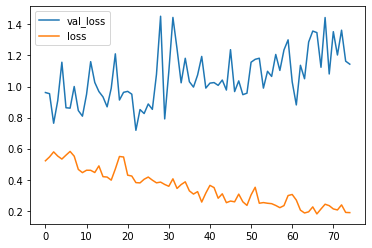

In [22]:
df_epoch_hist[['val_loss','loss']].plot()

In [23]:
# df_epoch_hist.to_csv('../artifact/epoch_hist_2-overfit2.csv')

In [72]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model-colab3.h5')
# model_load = load_model(PATH_MODEL + 'just_cake_model-colab2.h5')

# model_load.evaluate(train_generator)

24/24 [==============================] - 25s 1s/step - loss: 0.1963 - accuracy: 0.9380 - categorical_accuracy: 0.9380 - auc_1: 0.9953


[0.19634591042995453,
 0.9379947185516357,
 0.9379947185516357,
 0.9953163862228394]

In [79]:
# true_labels = val_generator.classes
# predictions = model_load.predict(val_generator)

true_labels = train_generator.classes
# predictions = model_load.predict_generator(train_generator)
predictions = model_load.predict(train_generator)
# predictions = just_cake_model.predict(train_generator)


y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

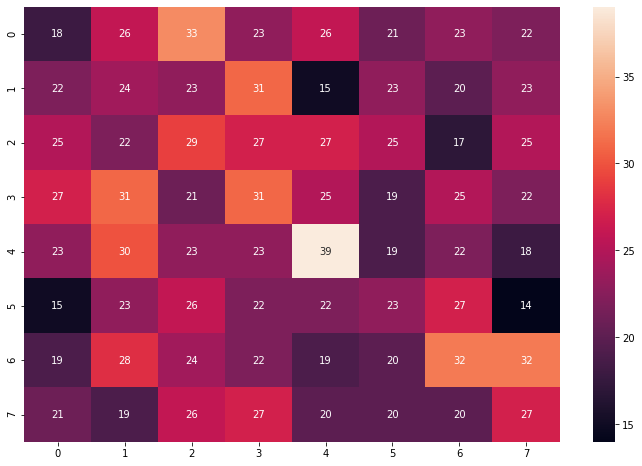

In [80]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [82]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.09      0.10       192
           1       0.12      0.13      0.12       181
           2       0.14      0.15      0.14       197
           3       0.15      0.15      0.15       201
           4       0.20      0.20      0.20       197
           5       0.14      0.13      0.13       172
           6       0.17      0.16      0.17       196
           7       0.15      0.15      0.15       180

    accuracy                           0.15      1516
   macro avg       0.15      0.15      0.15      1516
weighted avg       0.15      0.15      0.15      1516

